Originally meant for preprocessing, this notebook is used to generate data sets that serve as experimental groups in order to study the effects of unsupervised discretization. As our chosen training data is all continuous, discretization is deployed to determine the effect on training data. It begins by exploring techniques for discretization (Part 1), and then establishes two approaches for optimizing the number of bins in a given discretized variable, the first being cumulative variance and the second cumulative entropy present in the variable. The cumulative values for the variable are based on that found in each of the bins for a variable. The relative value of these measures were used to establish the best number of bins for a given a binning technique for a given continuous variable (with further details in Part 2). Finally, specific ensembles of the different techniques were established to test the effectiveness combining binning approaches based on one of two different measures: overall change to correlation between variables and overall change to mutual information (with further detail in Part 3).

___
# Part 1: Exploration of Discretization Techniques
___

Import Dependencies

In [6]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
import pickle

warnings.filterwarnings('ignore')
np.random.seed(42)

Retrieves Data

In [127]:
df = pd.read_csv('preprocessed_data.csv').iloc[:,1:10]
class_var = df['class']
df.head()

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123


In [128]:
df.dtypes

alpha       float64
delta       float64
u           float64
g           float64
r           float64
i           float64
z           float64
class        object
redshift    float64
dtype: object

Explores discretization techniques for the same variable "u" to explore the distibution changes due to the deployed technique. The techniques explored include equal bin width (the range of values included in the bin are the same), equal bin frequency (the width will vary to ensure that all of the bins have the same number of data objects), and kmeans (which uses distance measures to create k bins of data based on the central value of each bin, yields both varying width and frequency between bins in a given variable).

In [129]:
u = pd.DataFrame(df.u)
u.head()


,u
0,23.87882
1,24.77759
2,25.26307
3,22.13682
4,19.43718


double checks that outliers removed in outlier_analysis.ipynb

In [133]:
u.nsmallest(1,'u')

,u
54011,14.31105


Histogram prior to unsupervised discretization techniques.

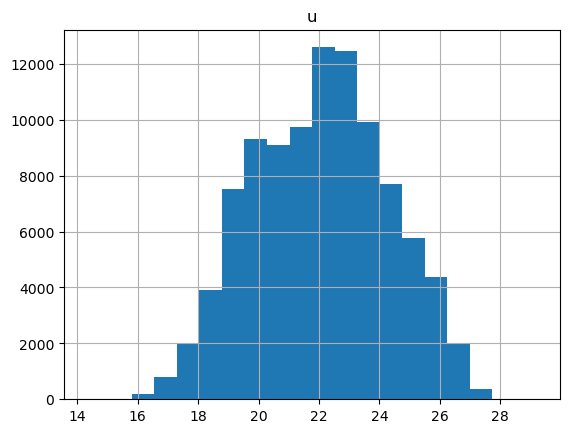

In [134]:
u.hist(bins = 20)
plt.show()

Sets up and fits the discretizer with uniform discretization (bins of same width).

In [ ]:
dc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
dc.fit(u)
Xu = dc.transform(u)
print(Xu)

Displays histogram after uniform discretization

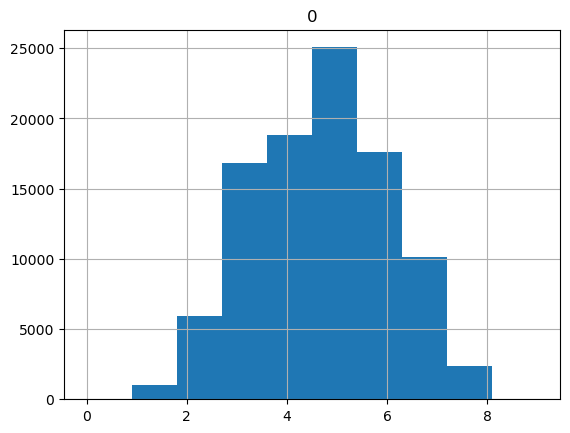

In [137]:
Xd = pd.DataFrame(Xu)
Xd.hist(bins = 10)
plt.show()

In [138]:
print(dc.bin_edges_)

[array([14.31105 , 15.803383, 17.295716, 18.788049, 20.280382, 21.772715,
        23.265048, 24.757381, 26.249714, 27.742047, 29.23438 ])          ]


Sets up and fits the discretizer with quantil discretization (bins of same number of data objects).

In [ ]:
dc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile');
dc.fit(u)
Xu = dc.transform(u)
print(Xu)

Displays histogram after quantile discretization

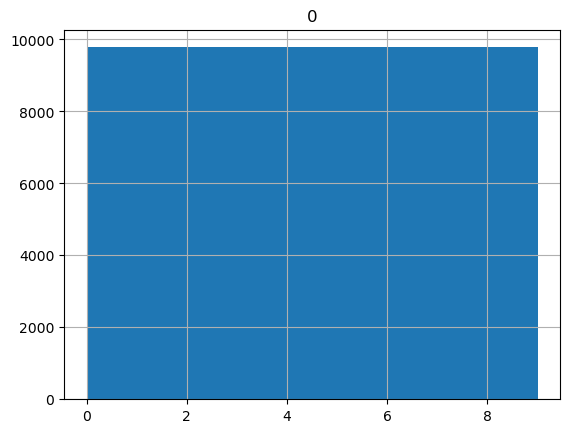

In [141]:
Xd = pd.DataFrame(Xu)
Xd.hist(bins=10)
plt.show()

In [142]:
print(dc.bin_edges_)

[array([14.31105 , 19.119002, 19.949052, 20.721462, 21.528726, 22.15742 ,
        22.72338 , 23.31888 , 24.070266, 25.093166, 29.23438 ])          ]


Sets up and fits the discretizer with kmeans discretization (bins of variable frequency and width).

In [143]:
dc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans');

In [144]:
dc.fit(u)
Xu = dc.transform(u).astype(int)
Xu.astype(int).dtype

[[7]
 [8]
 [8]
 ...
 [4]
 [8]
 [5]]


Displays histogram after kmeans discretization

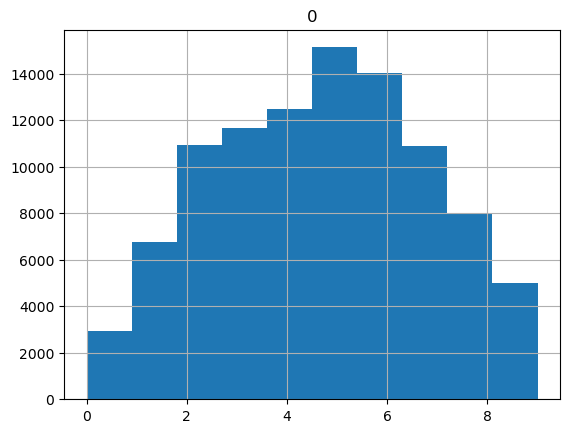

In [146]:
Xd = pd.DataFrame(Xu)
Xd.hist(bins=10)
plt.show()

In [147]:
print(dc.bin_edges_)

[array([14.31105   , 18.01466338, 19.11349395, 20.03590366, 20.98019309,
        21.91386403, 22.79690257, 23.71600339, 24.70441566, 25.7664468 ,
        29.23438   ])                                                   ]


____
# Part2: K-optimization: 
___

Each of the above techniques is assessed on each continuous training variable in order to find the best k-value for each variable per discretization technique. Each technique exploits an inherent measure for identifying the optimal number of bins (k) across techniques deployed on each continuous variable. These measures ultimately define groups of test datasets. The first is variance in each of the variables post discretization. It is assessed iteratively per k-value candidate by calculating a weighted sum of the individual variances of the bins fitted to the variable. The distribution of weighted sum variances are evaluated to find the k-value associated with an inititial inflection point (hueristically the location of where the "second derivitive" values change sign from negative to positive). The sum is weighted because variance is in part defined by the inverse of the number of instances in the distribution it is found for which leads to smaller bin sizes having a disproportionate impact on the overal variance measure. The second measure is entropy which is a measure of the "randomness" of the data withing the bins which is also found for the entire binned variable by summing the measure in each bin . Because it is not dependent on the number of instances in the bin, it does not need to be weighted. In a similar fashion to variance, the inflection point of the distribution entropy for k candidates was utilized to identify the ideal k-value for a given variable and given technique but the inflection point reflects a change from postitive to negative. Ultimately per optimization measure, a set of three candidate-discretizations are generated for each continuous variable- one for each binning technique- so that each has a specifically tailored number of bins. 



functions for assessing variance and entropy

In [148]:
def wt_sum_variance(df: pd.DataFrame)->float:
    """
        establishes cumulative variance for binning
        of a variable
    """
    # stores weighted variances of bins
    bin_wt_variances = []
    
    # list of bin number identifiers that are to be iterated through to find the weighted variance of each 
    bins = df.iloc[:,1].unique()

    for bin in bins:
        # get bin members
        bin_members = df[df.iloc[:, 1] == bin].iloc[:, 0]
        # appends bin_wt_variances with next value
        bin_wt_variances.append((bin_members.shape[0]/df.shape[0])*bin_members.var())

    return sum(bin_wt_variances)



In [149]:
def sum_entropy(df: pd.DataFrame)-> float:
    bin_entropies = []

    bins = df.iloc[:,1].unique()

    for bin in bins:
        bin_members = df[df.iloc[:,1] == bin]. iloc[:,0]

        p = bin_members.shape[0]/df.shape[0]
        bin_entropies.append(-p*np.log2(p))

    return sum(bin_entropies)

Functions to assess k-values associated with inflection points for bin number optimization measures.

In [ ]:
def best_k_index_variance(variances: list) -> int:
    """
        finds the correct location of the inflection pt 
        in the change in variance
    """
    # second derivative of variance
    acceleration = np.diff(np.diff(variances))
    
    for k in range(1, len(acceleration)): 
        # finds inflection in variance
        if acceleration[k-1] < 0 and acceleration[k] > 0:
            # "+2" addresses indicial shift when finding f''
            return k + 2
    return -1  # if no inflection point, return indicator

very similar definition for finding elbow/inflection in the distribution of entropies for k-candidates

In [ ]:
def best_k_index_entropy(entropies: list) -> int:
    """
        finds the correct location of the inflection pt 
        in the change in entropies
    """
    # second derivative of entropy
    acceleration = np.diff(np.diff(entropies))
    for k in range(1, len(acceleration)): 
        # finds inflection in variance
        if acceleration[k-1] > 0 and acceleration[k] < 0:
            # "+2" addresses indicial shift when finding f''
            return k + 2
    return -1  # if no inflection point, return indicator

#### K-value optimizations:
The following cells deploy the above functions on a range of candidate k-values. The range maximum is determined using the variance and absolute frequency of all instances in the predictive variables. The frequency is inherently constant across variables but the variance is specific to each. The minimum is the number of classes in the predicted variable. The resulting candidated variable discretizations were appended to a data frame respective to the measure used for optimization.

finds optimal k's for binned candidate variables relative to variance and appends them to a data frame iterated through in part 3.

In [152]:
# minimum k candidate range
minK = len(df["class"].unique())

# chunks of k candidates to test: prevents running all potential k's if second deriv of variace reveals inflcation point.
chunk = 10

# predictor df
variance_predict_vars = df.columns[df.dtypes == "float64"]
variance_predict_df = df[variance_predict_vars]
variance_predict_df.drop(list(variance_predict_df.filter(regex = 'ID')), axis = 1, inplace = True)

# predictor variables list
colNames = variance_predict_df.columns

for col in colNames:
    x = variance_predict_df[col]

    # ensures that the 
    maxK = min(int(minK * (len(x)//x.var())), 1000)
    print(f"{col}_maxK: {maxK}")
    k_candidates = np.arange(minK,maxK,1, dtype= int)

    # dictionaries: key = k-value, value = labels
    width_dict = defaultdict(list)
    freq_dict = defaultdict(list)
    kmeans_dict = defaultdict(list)

    # lists: store variances for each bin type
    width_variances = []
    freq_variances = []
    kmeans_variances = []

    for i in range(minK, maxK, chunk):

        # protects from out of bounds at end of loop range
        end_i = min(i+chunk, maxK)   

        for k in range(i, end_i):
            
            # discretizer objects per k
            DC_width = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='uniform') 
        
            # populates the dictionaries
            width_dict[k] = DC_width.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
            
            # creates dfs for variance evaluation
            width_df = pd.DataFrame({'column': x,
                                    'bins': width_dict[k]})

            # populates variance lists
            width_variances.append(wt_sum_variance(width_df))


        best_width_i = best_k_index_variance(width_variances)

        if best_width_i == -1 :
            continue

        best_k_width = k_candidates[best_width_i]
        print(f"{col} width k: {best_k_width}")
        variance_predict_df[f"{col}_width"] = width_dict[best_k_width]

        break

    for i in range(minK, maxK, chunk):

        # protects from outof bounds at end of loop range
        end_i = min(i+chunk, maxK)   

        for k in range(i, end_i):
            
            DC_freq = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='quantile')
        
            # populates the dictionaries
            freq_dict[k] = DC_freq.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()

            # creates dfs for variance evaluation
            freq_df = pd.DataFrame({'column': x,
                                    'bins': freq_dict[k]})
            
            # populates variance lists
            freq_variances.append(wt_sum_variance(freq_df))

        best_freq_i = best_k_index_variance(freq_variances)

        if best_freq_i == -1 :
            continue

        
        best_k_freq = k_candidates[best_freq_i]
        print(f"{col} frequency k: {best_k_freq}")
        variance_predict_df[f"{col}_freq"] = freq_dict[best_k_freq]

        break

    for i in range(minK, maxK, chunk):

        # protects from outof bounds at end of loop range
        end_i = min(i+chunk, maxK)   

        for k in range(i, end_i):
            
            DC_kmeans = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='kmeans')
        
            # populates the dictionaries
            kmeans_dict[k] = DC_kmeans.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()

            # creates dfs for variance evaluation
            kmeans_df = pd.DataFrame({'column': x,
                                    'bins': kmeans_dict[k]})
            
            # populates variance lists
            kmeans_variances.append(wt_sum_variance(kmeans_df))

        best_kmeans_i = best_k_index_variance(kmeans_variances)

        if best_kmeans_i == -1 :
            continue

        
        best_k_kmeans = k_candidates[best_kmeans_i]
        print(f"{col} kmeans k: {best_k_kmeans}")
        variance_predict_df[f"{col}_kmeans"] = kmeans_dict[best_k_kmeans]
        
        break


variance_predict_df.head()


alpha_maxK: 30
alpha width k: 8
alpha frequency k: 12
alpha kmeans k: 10
delta_maxK: 759
delta width k: 8
delta frequency k: 11
delta kmeans k: 10
u_maxK: 1000
u width k: 28
u frequency k: 49
u kmeans k: 16
g_maxK: 1000
g width k: 17
g frequency k: 41
g kmeans k: 19
r_maxK: 1000
r width k: 9
r frequency k: 51
r kmeans k: 20
i_maxK: 1000
i width k: 6
i frequency k: 38
i kmeans k: 17
z_maxK: 1000
z width k: 6
z frequency k: 68
z kmeans k: 14
redshift_maxK: 1000
redshift width k: 18
redshift frequency k: 34
redshift kmeans k: 12


,alpha,delta,u,g,r,i,z,redshift,alpha_width,alpha_freq,...,r_kmeans,i_width,i_freq,i_kmeans,z_width,z_freq,z_kmeans,redshift_width,redshift_freq,redshift_kmeans
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,3,3,...,11,3,17,8,3,30,6,4,24,4
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,3,4,...,17,4,33,13,4,65,12,5,27,5
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,3,4,...,12,3,18,8,3,33,7,4,24,4
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,7,11,...,15,3,29,11,3,39,7,6,28,5
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,7,11,...,3,1,1,2,1,2,1,0,11,1


code finds the best k relative to entropy inflection point.

In [178]:
def best_k_index_entropy(entropies: list) -> int:
    """
        finds the correct location of the inflection pt 
        in the change in entropies
    """
    # second derivative of variance
    acceleration = np.diff(np.diff(entropies))
    # starting at one corrects for first indicial shift due to diff array 
    for k in range(1, len(acceleration)): 
        # finds inflection in variance
        if acceleration[k-1] > 0 and acceleration[k] < 0:
            # "+2" addresses second indicial shift
            return k + 2
    # safety: if inflection can't be found, uses smallest change
    return np.argmin(acceleration) + 2

finds optimal k's for binned candidate variables relative to entropy and appends them to a data frame iterated through in part 3.

In [154]:
# minimum k candidate range
minK = len(df["class"].unique())


# predictor df
entropy_predict_vars = df.columns[df.dtypes == "float64"]
entropy_predict_df = df[entropy_predict_vars]
entropy_predict_df.drop(list(entropy_predict_df.filter(regex = 'ID')), axis = 1, inplace = True)

# predictor variables list
colNames = entropy_predict_df.columns

for col in colNames:
    x = entropy_predict_df[col]

    # ensures that there are sufficient candidates without being excessive
    maxK = min(int(minK * (len(x)//x.var())), 100)
    print(f"{col}_maxK: {maxK}")
    k_candidates = np.arange(minK,maxK,1, dtype= int)

    # dictionaries: key = k-value, value = labels
    width_dict = defaultdict(list)
    freq_dict = defaultdict(list)
    kmeans_dict = defaultdict(list)

    # lists: store variances for each bin type
    width_entropies = []
    freq_entropies = []
    kmeans_entropies = []

     

    for k in range(i, maxK):
            
        # discretizer objects per k
        DC_width = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='uniform') 
        DC_freq = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='quantile')
        DC_kmeans = KBinsDiscretizer(n_bins=k, encode='ordinal', strategy='kmeans')
    
        # populates the dictionaries
        width_dict[k] = DC_width.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
        freq_dict[k] = DC_freq.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
        kmeans_dict[k] = DC_kmeans.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
        
        # creates dfs for variance evaluation
        width_df = pd.DataFrame({'column': x,
                                'bins': width_dict[k]})
        freq_df = pd.DataFrame({'column': x,
                            'bins': freq_dict[k]})
        kmeans_df = pd.DataFrame({'column': x,
                        'bins': kmeans_dict[k]})

        # populates entropy lists
        width_entropies.append(sum_entropy(width_df))
        freq_entropies.append(sum_entropy(freq_df))
        kmeans_entropies.append(sum_entropy(kmeans_df))


    best_width_i = best_k_index_entropy(width_entropies)
    best_freq_i = best_k_index_entropy(freq_entropies)
    best_kmeans_i = best_k_index_entropy(kmeans_entropies)



    best_k_width = k_candidates[best_width_i]
    best_k_freq = k_candidates[best_freq_i]
    best_k_kmeans = k_candidates[best_kmeans_i]
    

    print(f"{col} width k: {best_k_width}")
    print(f"{col} frequency k: {best_k_freq}")
    print(f"{col} kmeans k: {best_k_kmeans}")


    entropy_predict_df[f"{col}_width"] = width_dict[best_k_width]
    entropy_predict_df[f"{col}_freq"] = freq_dict[best_k_freq]
    entropy_predict_df[f"{col}_kmeans"] = kmeans_dict[best_k_kmeans]



entropy_predict_df.head()

alpha_maxK: 30
alpha width k: 9
alpha frequency k: 5
alpha kmeans k: 10
delta_maxK: 100
delta width k: 9
delta frequency k: 5
delta kmeans k: 11
u_maxK: 100
u width k: 12
u frequency k: 5
u kmeans k: 12
g_maxK: 100
g width k: 6
g frequency k: 5
g kmeans k: 17
r_maxK: 100
r width k: 6
r frequency k: 5
r kmeans k: 7
i_maxK: 100
i width k: 6
i frequency k: 5
i kmeans k: 11
z_maxK: 100
z width k: 7
z frequency k: 5
z kmeans k: 8
redshift_maxK: 100
redshift width k: 15
redshift frequency k: 44
redshift kmeans k: 6


,alpha,delta,u,g,r,i,z,redshift,alpha_width,alpha_freq,...,r_kmeans,i_width,i_freq,i_kmeans,z_width,z_freq,z_kmeans,redshift_width,redshift_freq,redshift_kmeans
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,3,1,...,4,3,2,5,3,2,4,3,31,2
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,3,1,...,6,4,4,9,5,4,7,4,35,2
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,3,1,...,4,3,2,6,3,2,4,3,32,2
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,8,4,...,5,3,3,8,3,2,4,5,37,2
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,8,4,...,0,1,0,1,1,0,0,0,14,0


____
# Part3: Correlation/Mutual Information Optimization for experimental groups
___

The data frames of binned candidates for representation of the original continuous predictive variables are utilized to exhaustively evaluate their combinations so that each combination has a single binned version of the original predicitve variables represented once. Two different approaches are used to evaluate each combination. The first is the maximum reduction of correlation between variables, relative to the correlation that exists between the original continuous predictors. The second is the minimum increase in mutual information between variables relative to the continuous predictors. In both cases it is theorized that it is beneficial to have both of these measures be as small as possible for the transformed data that the models will train on as they measure the amount to which each variable is similar to other variables. While some machine learning algorithms can handle training on variables with high levels of similarity others cannot and in some cases it can cause greater complexity in the models. Correlation reflects the covariation of the variables it is measured between (cite probability text) but is resticted to linear variation. Mutual Information is a more generalized meausure of similairty between variables.It includes linear relationships but also includes nonlinear relationships. It tends to increase with discretization suggesting artificial relationships between variables due to the higher level of shared values due to the bins created.  

In [155]:
variance_predict_df.head()

,alpha,delta,u,g,r,i,z,redshift,alpha_width,alpha_freq,...,r_kmeans,i_width,i_freq,i_kmeans,z_width,z_freq,z_kmeans,redshift_width,redshift_freq,redshift_kmeans
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,3,3,...,11,3,17,8,3,30,6,4,24,4
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,3,4,...,17,4,33,13,4,65,12,5,27,5
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,3,4,...,12,3,18,8,3,33,7,4,24,4
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,7,11,...,15,3,29,11,3,39,7,6,28,5
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,7,11,...,3,1,1,2,1,2,1,0,11,1


In [156]:
entropy_predict_df.head()

,alpha,delta,u,g,r,i,z,redshift,alpha_width,alpha_freq,...,r_kmeans,i_width,i_freq,i_kmeans,z_width,z_freq,z_kmeans,redshift_width,redshift_freq,redshift_kmeans
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,3,1,...,4,3,2,5,3,2,4,3,31,2
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,3,1,...,6,4,4,9,5,4,7,4,35,2
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,3,1,...,4,3,2,6,3,2,4,3,32,2
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,8,4,...,5,3,3,8,3,2,4,5,37,2
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,8,4,...,0,1,0,1,1,0,0,0,14,0


User functions for Mutual Information Matrices generatation: used in test group 1_b and test group 2_b and control_b
* continuous_mi is heuristic and is not restricted to maximum of one. It is only used with the original data to visualize it and compare it to the binned data ensembles

In [34]:
def continuous_mi(df: pd.DataFrame) -> np.ndarray:
    cols = df.columns
    length = len(cols)
    mi_matrix = np.zeros((length, length))

    for i in range(length):
        for j in range(length):

            # conditionally makes diagonals one (simplifies evaluation of change in mi across matrices)
            if i == j:
                mi_matrix[i,j] = 1
            else:
                mi = mutual_info_regression(df[[cols[i]]], df[cols[j]])[0]
                norm_mi = mi/np.sqrt(np.var(df[cols[i]])*np.var(df[cols[j]])) # estimate instead of entropy (which is a pain in continuous data)
                mi_matrix[i,j] = norm_mi

    return mi_matrix

In [37]:
def discrete_mi(df: pd.DataFrame) -> np.ndarray:
    cols = df.columns
    length = len(cols)
    mi_matrix = np.zeros((length, length))

    for i in range(length):
        for j in range(length):
            mi = mutual_info_score(df[cols[i]], df[cols[j]])
           
            norm_mi = mi/np.sqrt(entropy(np.bincount(df[cols[i]]))*entropy(np.bincount(df[cols[j]])))
            mi_matrix[i,j] = norm_mi

    return mi_matrix


### Experiment:

**experimental groups**:
* 1_a variance optimized bin size; correlation optimized technique ensemble
* 1_b variance optimized bin size; mutual information optimized technique ensemble
* 1_c randomized bin sizes and ensemple
* 2_a entropy optimized bin size; correlation optimized technique ensemble
* 2_b entropy optimized bin size; mutual information optimized technique ensemble
* 2_c randomized bin sizes and ensemple (equals 1_c)
* control: original continuous predictors

  
The **experimental design**:
* train on each test group, and compare to training on the control group

Outcome:
* the greatest success relative to the control group will determine if (a) discretization matters at all in the efficacy of training different classifier models and (b) if optimization using variance measures has any impact on the efficacy. 

Predetermined hypothesis:
* answers:  do you think discretization will improve on the effectiveness of the models overall and if so do you think the prescribed discretization technique will be more or less effective than random discretization? 


___
___
Control group prep
___
___

The heat-mapped correlation matrix of the continuous versions of the predictive variables.

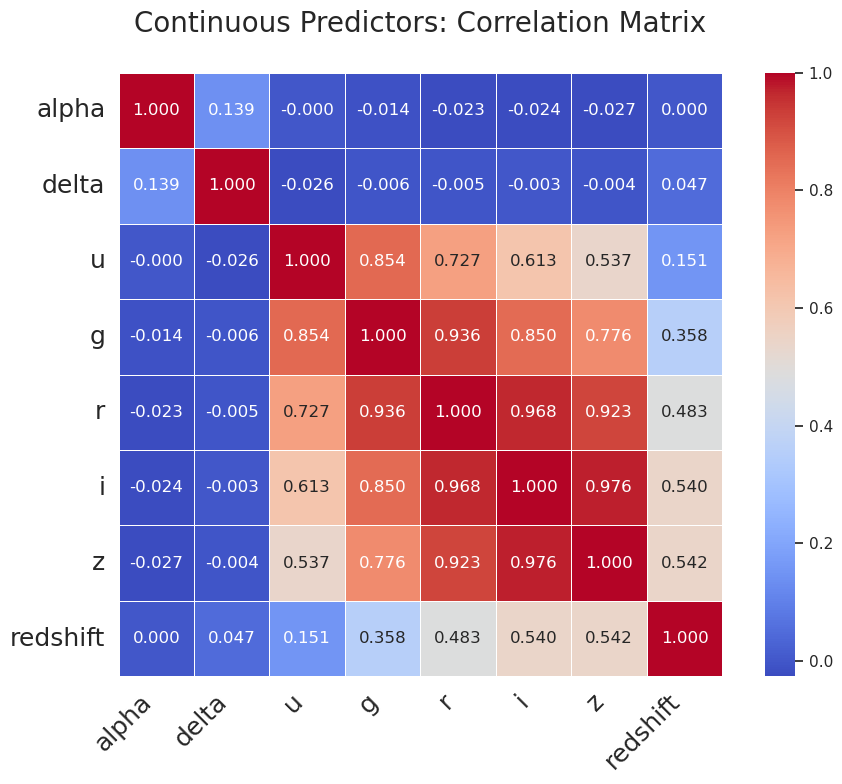

In [54]:
# separates continuous predictors from discretized
# contPred_df = df.drop('class',axis=1)
# contPred_df.to_csv("../Dataset/Control_Group.csv", index= False)

contPred_df = pd.read_csv("../Dataset/Control_Group.csv")
var_corr_matrix = contPred_df.corr()

var_corr_matrix.style\
    .format(precision = 3)\
    .format_index(str.upper, axis = 0)\
    .format_index(str.upper, axis = 1)\
    .background_gradient(cmap='coolwarm')



plt.figure(figsize=(10, 8))

sns.heatmap(var_corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Continuous Predictors: Correlation Matrix\n", 
          fontsize = 20
          )
plt.xticks(rotation=45, ha='right',
           fontsize = 18
           )
plt.yticks(rotation=0, 
           fontsize = 18
           )
plt.tight_layout()

# To save the plot
plt.savefig("../IMGs/continuousPredictors_corrheatmap.png", dpi=300)
plt.show()


Heat map of Mutual Info of original continuous predictors

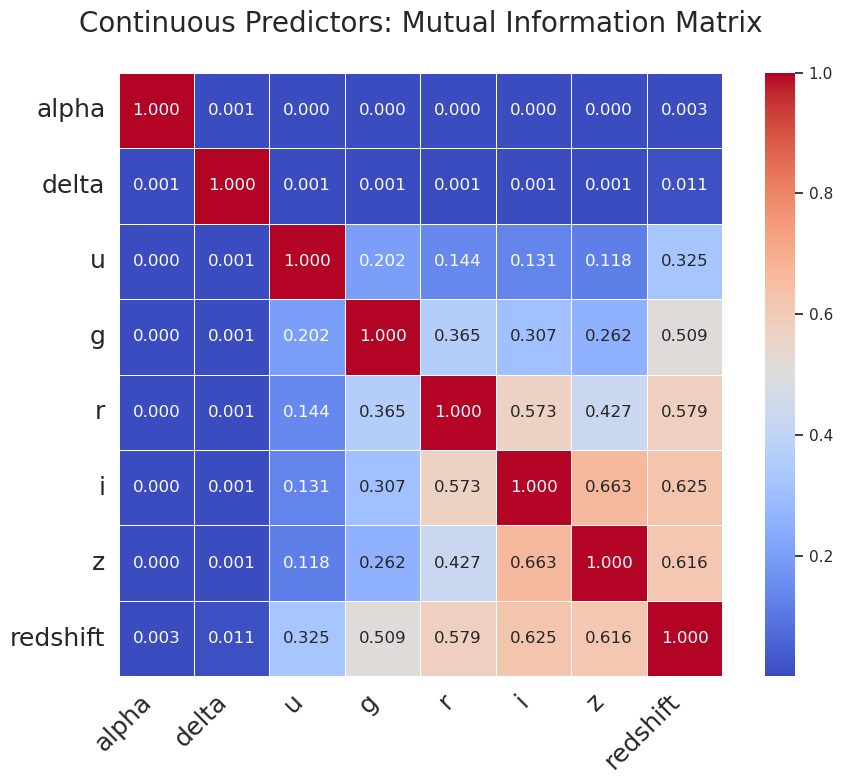

In [60]:
cols = contPred_df.columns

# because numpy matrix, adds var names back in
best_df_mi_matrix = pd.DataFrame(continuous_mi(contPred_df), index= cols, columns=cols)
best_df_mi_matrix

best_df_mi_matrix.style\
    .format(precision = 3)\
    .format_index(str.upper, axis = 0)\
    .format_index(str.upper, axis = 1)\
    .background_gradient(cmap='coolwarm')

plt.figure(figsize=(10, 8))

sns.heatmap(best_df_mi_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Continuous Predictors: Mutual Information Matrix\n", 
          fontsize = 20
          )
plt.xticks(rotation=45, ha='right',
           fontsize = 18
           )
plt.yticks(rotation=0, 
           fontsize = 18
           )
plt.tight_layout()

# To save the plot
plt.savefig("../IMGs/continuousPredictors_miheatmap.png", dpi=300)
plt.show()

___
___
Test group 1 prep
___
___

Test Group 1 consists of data frames of optimized discretizations of continuous predictive variables. The number of bins is based on variance measures. The bin type ensembles are based on both reduction of correlation across variables (1_a) and reduction of mutual information across variables (1_b). Both correlation and mutual information measure the level of dependency between variables but correlation reveals variation that is linear only while mutual information can have relationships that are nonlinear as well as linear. (1_c) tests random selection of bin sizes and tehcnique ensembles.

#### Test Group 1_a

Based in variance metrics, creates list of "mosaic" data frames that reflect all the combinations of the discretized predictive variables relative to the techniques used to create them. The bins are based on the optimization through correlation reduction.

In [ ]:
# separates original discretized predictors from continuous
var_discPred_df = variance_predict_df.iloc[:,8:variance_predict_df.shape[1]]

# strips the variable identifier from the matrix
var_corr_matrix = var_corr_matrix.values

# builds name lists based on names of continuous variables s.t. each list has 3 discretized columns corresponding to each continuous name
contVar_names = contPred_df.columns

discVar_names = list(var_discPred_df.columns)

# assigns appropriate names to distinguishing variables
alpha_names, delta_names, u_names, g_names, r_names, i_names, z_names, redshift_names = [discVar_names[i:i+3] for i in range(0,len(discVar_names),3)]

mosaics_list = []



# iteratively combine binning type var per continuous names with each other s.t there is only one version of binned continuous var in the new df
for a in alpha_names:
    for d in delta_names:
        for u in u_names:
            for g in g_names:
                for r in r_names:
                    for i in i_names:
                        for z in z_names:
                            for red in redshift_names:
                                group_names = [a,d,u,g,r,i,z,red]
                                df = var_discPred_df[group_names]
                                df_cols = df.columns
                                # print(df.head(3))
                                disc_cor_mat = df.corr().values
                                # messed up commented line below: should be final - initial 
                                # diffCor_mat = -(corr_matrix - cor_mat)
                                diffCor_mat = -(disc_cor_mat - var_corr_matrix)
                                # print(diffCor_mat)
                                summed_corDiff = np.sum(diffCor_mat)
                                # print(cumm_diffCor)
                                obj = {
                                      'variable_names' : df_cols,
                                    #   'df' : df,
                                      'cor_mat' : disc_cor_mat,
                                      'diffCor_mat' : diffCor_mat,
                                      'summed_corDiff' : summed_corDiff
                                    }
                                mosaics_list.append(obj)

                    

Gets the combinations of the optimized discretized variables from mosaics list that reduce the correlation the to the greatest degree and the the combination that actually increases the overall correlation.

In [ ]:
sorted_mosaics_list = sorted(mosaics_list, key = lambda x: x["summed_corDiff"])

CorChange_best_df = var_discPred_df[sorted_mosaics_list[len(sorted_mosaics_list)-1]['variable_names']]


CorChange_best_df.head()

# Creates Test Group 1_a df
CorChange_best_df.to_csv("../Dataset/TestGroup_1a.csv", index= False)

Heat map of best variance optimized ensemble by correlation

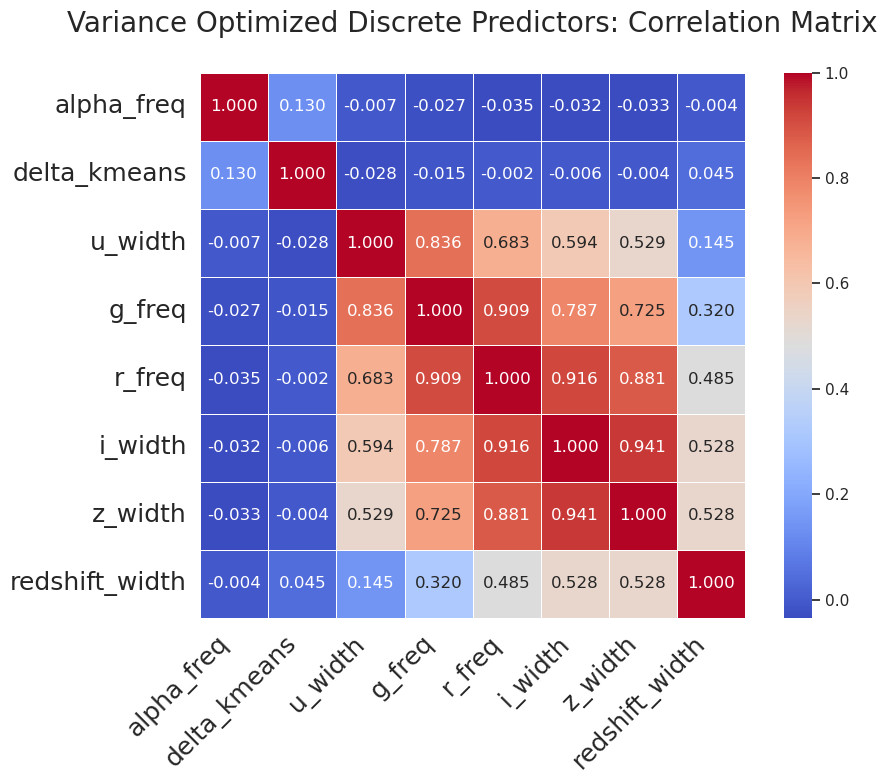

In [56]:
CorChange_best_df1 = pd.read_csv("../Dataset/TestGroup_1a.csv")
best_df_corr_matrix = CorChange_best_df.corr()

best_df_corr_matrix.style\
    .format(precision = 3)\
    .format_index(str.upper, axis = 0)\
    .format_index(str.upper, axis = 1)\
    .background_gradient(cmap='coolwarm')

plt.figure(figsize=(10, 8))

sns.heatmap(best_df_corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Variance Optimized Discrete Predictors: Correlation Matrix\n", 
          fontsize = 20
          )
plt.xticks(rotation=45, ha='right',
           fontsize = 18
           )
plt.yticks(rotation=0, 
           fontsize = 18
           )
plt.tight_layout()

# To save the plot
plt.savefig("../IMGs/VarDiscrete_Predictors_corrheatmap.png", dpi=300)
plt.show()

### Test Group 1_b

Based in variance metrics, creates list of "mosaic" data frames that reflect all the combinations of the discretized predictive variables relative to the techniques used to create them. The bins are based on the optimization through mutual information reduction.

In [163]:
test_df = variance_predict_df.iloc[:,[8,11,14,17,20]]

print(test_df.head())

discrete_mi(test_df)

   alpha_width  delta_width  u_width  g_width  r_width
0            3            4       17       10        5
1            3            3       19       11        6
2            3            4       20       11        5
3            7            1       14       12        6
4            7            3        9        4        1


array([[1.        , 0.12454808, 0.00762735, 0.01234982, 0.01719893],
       [0.12454808, 1.        , 0.00376838, 0.00549696, 0.00833369],
       [0.00762735, 0.00376838, 1.        , 0.31583494, 0.22122235],
       [0.01234982, 0.00549696, 0.31583494, 1.        , 0.45679059],
       [0.01719893, 0.00833369, 0.22122235, 0.45679059, 1.        ]])

In [165]:
# separates original discretized predictors from continuous
var_discPred_df = variance_predict_df.iloc[:,8:variance_predict_df.shape[1]]

# creates continuous mutual information matrix
var_mi_matrix = continuous_mi(contPred_df)
print(var_mi_matrix)

# builds name lists based on names of continuous variables s.t. each list has 3 discretized columns corresponding to each continuous name
contVar_names = contPred_df.columns

discVar_names = list(var_discPred_df.columns)

# assigns appropriate names to distinguishing variables
alpha_names, delta_names, u_names, g_names, r_names, i_names, z_names, redshift_names = [discVar_names[i:i+3] for i in range(0,len(discVar_names),3)]

mosaics_list = []



# iteratively combine binning type variables per continuous names with each other s.t there is only one version of binned continuous var in the new df
for a in alpha_names:
    for d in delta_names:
        for u in u_names:
            for g in g_names:
                for r in r_names:
                    for i in i_names:
                        for z in z_names:
                            for red in redshift_names:

                                group_names = [a,d,u,g,r,i,z,red]
                                df = var_discPred_df[group_names]
                                df_cols = df.columns

                                # creates mutual info matrix for current group
                                disc_mi_mat = discrete_mi(df)
                                diff_mi_mat = -(disc_mi_mat - var_mi_matrix)
                                summed_diff_mi = np.sum(diff_mi_mat)
                                obj = {
                                      'variable_names' : df_cols,
                                      'mi_mat' : disc_mi_mat,
                                      'diff_mi_mat' : diff_mi_mat,
                                      'summed_diff_mi' : summed_diff_mi
                                    }
                                mosaics_list.append(obj)


[[1.00000000e+00 7.01323172e-04 1.49121897e-04 1.95513517e-04
  3.10078540e-04 2.76432393e-04 2.28539242e-04 2.79542736e-03]
 [7.01323097e-04 1.00000000e+00 5.72637164e-04 9.96757989e-04
  1.32499352e-03 1.39910537e-03 1.26720697e-03 1.08914675e-02]
 [1.49106938e-04 5.72636314e-04 1.00000000e+00 2.01773197e-01
  1.43647401e-01 1.31277346e-01 1.18126407e-01 3.25216354e-01]
 [1.95522910e-04 9.96802529e-04 2.01777586e-01 1.00000000e+00
  3.64779670e-01 3.06518987e-01 2.61594313e-01 5.09232912e-01]
 [3.10103004e-04 1.32478034e-03 1.43654998e-01 3.64776701e-01
  1.00000000e+00 5.73004077e-01 4.26609126e-01 5.79062048e-01]
 [2.76446582e-04 1.39926281e-03 1.31276566e-01 3.06517845e-01
  5.73010297e-01 1.00000000e+00 6.63453112e-01 6.24924951e-01]
 [2.28495914e-04 1.26736641e-03 1.18134419e-01 2.61592910e-01
  4.26613219e-01 6.63453501e-01 1.00000000e+00 6.16019739e-01]
 [2.79546554e-03 1.08915551e-02 3.25202140e-01 5.09224195e-01
  5.79054920e-01 6.24920170e-01 6.16006492e-01 1.00000000e+00]]

In [166]:
mi_mosaics_copy = mosaics_list.copy()

# don't want to run the above cell ever again:
with open('../Dataset/mi_mosaics_variance.pkl', 'wb') as f:
    pickle.dump(mi_mosaics_copy, f)

gets best combination of binned variables per mutual information

In [ ]:
sorted_mosaics_list = sorted(mosaics_list, key = lambda x: x["summed_diff_mi"])

miChange_best_df = var_discPred_df[sorted_mosaics_list[len(sorted_mosaics_list)-1]['variable_names']]

# Creates Test Group 1b df
miChange_best_df.to_csv("../Dataset/TestGroup_1b.csv", index=False)

Heat map of best variance optimized ensemble by Mutual Info

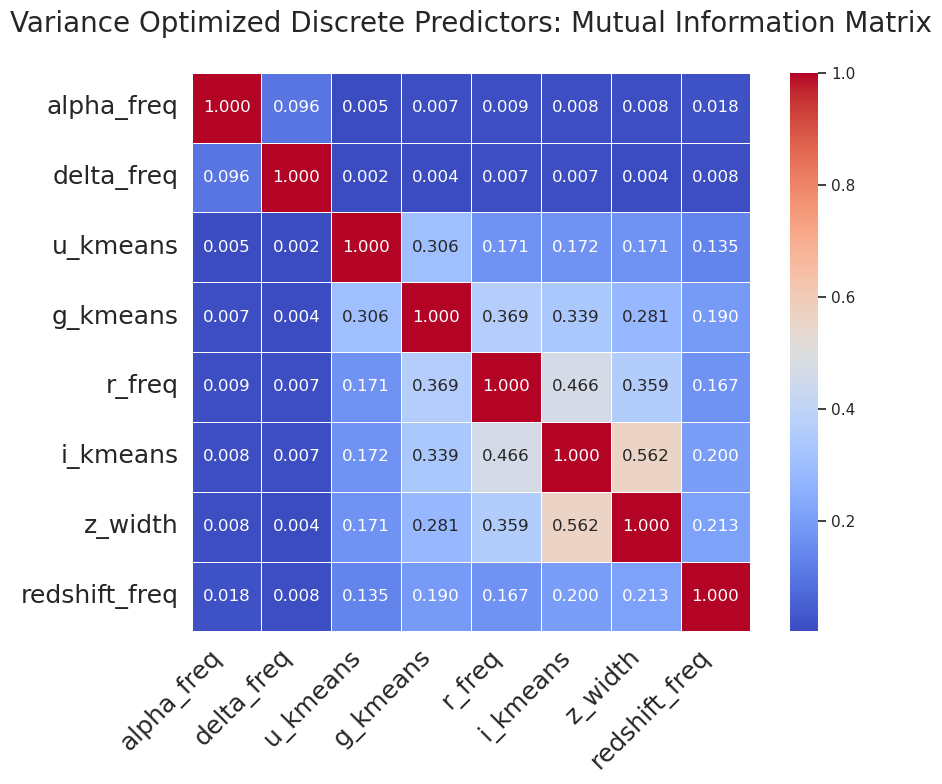

In [57]:
miChange_best_df = pd.read_csv("../Dataset/TestGroup_1b.csv")

cols = miChange_best_df.columns

# because numpy matrix, adds var names back in
best_df_mi_matrix = pd.DataFrame(discrete_mi(miChange_best_df), index= cols, columns=cols)
best_df_mi_matrix

best_df_mi_matrix.style\
    .format(precision = 3)\
    .format_index(str.upper, axis = 0)\
    .format_index(str.upper, axis = 1)\
    .background_gradient(cmap='coolwarm')



plt.figure(figsize=(10, 8))

sns.heatmap(best_df_mi_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Variance Optimized Discrete Predictors: Mutual Information Matrix\n", 
          fontsize = 20
          )
plt.xticks(rotation=45, ha='right',
           fontsize = 18
           )
plt.yticks(rotation=0, 
           fontsize = 18
           )
plt.tight_layout()

# To save the plot
plt.savefig("../IMGs/VarDiscrete_Predictors_miheatmap.png", dpi=300)
plt.show()

### Test group 1_c: 
Random selection of number of bins and binning techniques for transformation of each continuous predictive variable. 

In [187]:
kmin = 3
kmax = 60
varNames = df.columns

randomPredict_df = pd.DataFrame()

for var in varNames:
        choice = np.random.randint(1,4)
        x = df[var]
        if choice == 1:
                DC_width = KBinsDiscretizer(n_bins=np.random.randint(kmin,kmax+1), encode='ordinal', strategy='uniform')
                discVar = DC_width.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
                randomPredict_df[f"{var}_width"] = discVar
                 
        elif choice == 2:
                DC_freq = KBinsDiscretizer(n_bins=np.random.randint(kmin,kmax+1), encode='ordinal', strategy='quantile')
                discVar = DC_freq.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
                randomPredict_df[f"{var}_freq"] = discVar
        else:
                DC_kmeans = KBinsDiscretizer(n_bins=np.random.randint(kmin,kmax+1), encode='ordinal', strategy='kmeans')
                discVar = DC_kmeans.fit_transform(x.values.reshape(-1, 1)).astype(int).flatten()
                randomPredict_df[f"{var}_kmeans"] = discVar

randomPredict_df.to_csv("../Dataset/TestGroup_1c.csv", index=False)

___
___
Test group 2 prep
___
___

Test Group 2 consists of data frames of optimized discretizations of continuous predictive variables. The number of bins is based on entropy measures. The bin type ensembles are based on both reduction of correlation across variables (2_a) and reduction of mutual information across variables (2_b). Both correlation and mutual information measure the level of dependency between variables but correlation reveals variation that is linear only while mutual information can have relationships that are nonlinear as well as linear. (2_c) tests random selection of bin sizes and tehcnique ensembles.


Shows all versions of each discretized predictive variable

In [171]:
entropy_predict_df.head()

,alpha,delta,u,g,r,i,z,redshift,alpha_width,alpha_freq,...,r_kmeans,i_width,i_freq,i_kmeans,z_width,z_freq,z_kmeans,redshift_width,redshift_freq,redshift_kmeans
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,3,1,...,4,3,2,5,3,2,4,3,31,2
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,3,1,...,6,4,4,9,5,4,7,4,35,2
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,3,1,...,4,3,2,6,3,2,4,3,32,2
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,8,4,...,5,3,3,8,3,2,4,5,37,2
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,8,4,...,0,1,0,1,1,0,0,0,14,0


### Test Group 2_a

Based in entropy metrics, creates list of "mosaic" data frames that reflect all the combinations of the discretized predictive variables relative to the techniques used to create them. The bins are based on the optimization through correlation reduction.

In [173]:
# separate original discretized predictors from continuous
ent_discPred_df = entropy_predict_df.iloc[:,8:entropy_predict_df.shape[1]]
ent_contPred_df = entropy_predict_df.iloc[:,0:8]

# strips the variable identifier from the matrix
ent_corr_matrix = var_corr_matrix

# build name lists based on names of continuous variables s.t. each list has 3 discretized columns corresponding to each continuous name
contEnt_names = ent_contPred_df.columns

discEnt_names = list(ent_discPred_df.columns)

# assigns appropriate names to distinguishing variables
alpha_names, delta_names, u_names, g_names, r_names, i_names, z_names, redshift_names = [discEnt_names[i:i+3] for i in range(0,len(discEnt_names),3)]

ent_mosaics_list = []



# iteratively combine binning type var per continuous names with each other s.t there is only one version of binned continuous var in the new df
for a in alpha_names:
    for d in delta_names:
        for u in u_names:
            for g in g_names:
                for r in r_names:
                    for i in i_names:
                        for z in z_names:
                            for red in redshift_names:
                                group_names = [a,d,u,g,r,i,z,red]
                                df = ent_discPred_df[group_names]
                                df_cols = df.columns
                                disc_cor_mat = df.corr().values

                                diffCor_mat = -(disc_cor_mat - ent_corr_matrix)
                                summed_corDiff = np.sum(diffCor_mat)
                                
                                obj = {
                                      'variable_names' : df_cols,
                                      'cor_mat' : disc_cor_mat,
                                      'diffCor_mat' : diffCor_mat,
                                      'summed_corDiff' : summed_corDiff
                                    }
                                
                                ent_mosaics_list.append(obj)

                     

  # transform df into cor matrix
  # find and store difference between the continuous corr matrix and the mosaic cor matrix as well as cumulative absolute distance
  # order the mosaic dfs by greatest to least cumulative cor distance

In [186]:
sorted_mosaics_list = sorted(ent_mosaics_list, key = lambda x: x["summed_corDiff"])

corChange_best_df = ent_discPred_df[sorted_mosaics_list[len(sorted_mosaics_list)-1]['variable_names']]
# CorChange_worst_df = discPred_df[sorted_mosaics_list[0]['variable_names']]

# Creates Test Group 2a df
corChange_best_df.to_csv("../Dataset/TestGroup_2a.csv", index= False)

Heat map of best entropy optimized ensemble by Correlation

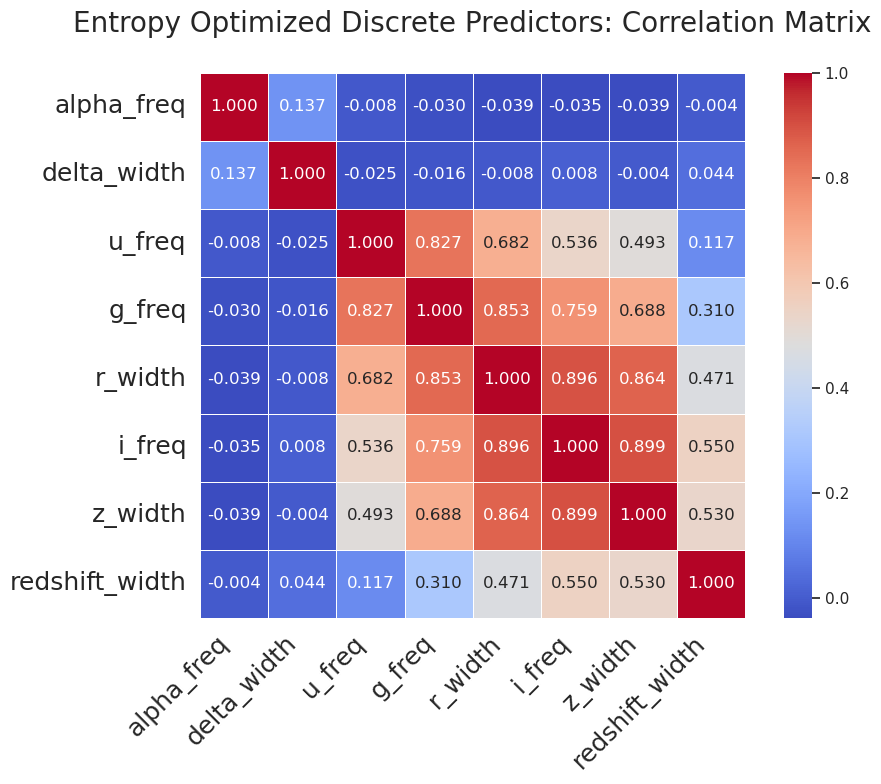

In [58]:
CorChange_best_df2 = pd.read_csv("../Dataset/TestGroup_2a.csv")

best_df_corr_matrix = CorChange_best_df2.corr()

best_df_corr_matrix.style\
    .format(precision = 3)\
    .format_index(str.upper, axis = 0)\
    .format_index(str.upper, axis = 1)\
    .background_gradient(cmap='coolwarm')

plt.figure(figsize=(10, 8))

sns.heatmap(best_df_corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Entropy Optimized Discrete Predictors: Correlation Matrix\n", 
          fontsize = 20
          )
plt.xticks(rotation=45, ha='right',
           fontsize = 18
           )
plt.yticks(rotation=0, 
           fontsize = 18
           )
plt.tight_layout()

# To save the plot
plt.savefig("../IMGs/EntDiscrete_Predictors_corrheatmap.png", dpi=300)
plt.show()

### Test Group 2_b

Based in entropy metrics, creates list of "mosaic" data frames that reflect all the combinations of the discretized predictive variables relative to the techniques used to create them. The bins are based on the optimization through mutual information reduction.

In [177]:
# separate original discretized predictors from continuous
ent_discPred_df = entropy_predict_df.iloc[:,8:entropy_predict_df.shape[1]]

# creates continuous mutual information matrix
ent_mi_matrix = continuous_mi(contPred_df)
print(ent_mi_matrix)

# build name lists based on names of continuous variables s.t. each list has 3 discretized columns corresponding to each continuous name
contEnt_names = contPred_df.columns

discEnt_names = list(ent_discPred_df.columns)

# assigns appropriate names to distinguishing variables
alpha_names, delta_names, u_names, g_names, r_names, i_names, z_names, redshift_names = [discEnt_names[i:i+3] for i in range(0,len(discEnt_names),3)]

mosaics_list = []



# iteratively combine binning type var per continuous names with each other s.t there is only one version of binned continuous var in the new df
for a in alpha_names:
    for d in delta_names:
        for u in u_names:
            for g in g_names:
                for r in r_names:
                    for i in i_names:
                        for z in z_names:
                            for red in redshift_names:

                                group_names = [a,d,u,g,r,i,z,red]
                                df = ent_discPred_df[group_names]
                                df_cols = df.columns

                                # creates mutual info matrix for current group
                                disc_mi_mat = discrete_mi(df)
                                diff_mi_mat = -(disc_mi_mat - ent_mi_matrix)
                                summed_diff_mi = np.sum(diff_mi_mat)
                                obj = {
                                      'variable_names' : df_cols,
                                      'mi_mat' : disc_mi_mat,
                                      'diff_mi_mat' : diff_mi_mat,
                                      'summed_diff_mi' : summed_diff_mi
                                    }
                                mosaics_list.append(obj)

[[1.00000000e+00 7.01323072e-04 1.49128249e-04 1.95510635e-04
  3.10080791e-04 2.76423274e-04 2.28489277e-04 2.79544529e-03]
 [7.01323080e-04 1.00000000e+00 5.72697954e-04 9.96813105e-04
  1.32496975e-03 1.39916935e-03 1.26709348e-03 1.08910569e-02]
 [1.49101373e-04 5.72611046e-04 1.00000000e+00 2.01776236e-01
  1.43651595e-01 1.31278240e-01 1.18117073e-01 3.25210024e-01]
 [1.95510267e-04 9.96800852e-04 2.01773068e-01 1.00000000e+00
  3.64779945e-01 3.06519095e-01 2.61592968e-01 5.09243336e-01]
 [3.10120800e-04 1.32489884e-03 1.43642276e-01 3.64775266e-01
  1.00000000e+00 5.73005387e-01 4.26615328e-01 5.79096774e-01]
 [2.76427270e-04 1.39915036e-03 1.31275310e-01 3.06516148e-01
  5.73006556e-01 1.00000000e+00 6.63452062e-01 6.24918292e-01]
 [2.28480536e-04 1.26706608e-03 1.18108908e-01 2.61597701e-01
  4.26613694e-01 6.63454102e-01 1.00000000e+00 6.15975828e-01]
 [2.79538139e-03 1.08913526e-02 3.25221265e-01 5.09265913e-01
  5.79099040e-01 6.24934833e-01 6.15978440e-01 1.00000000e+00]]

In [179]:
mi_mosaics_copy = mosaics_list.copy()

# don't want to run the above cell ever again either:
with open('../Dataset/mi_mosaics_entropy.pkl', 'wb') as f:
    pickle.dump(mi_mosaics_copy, f)

In [185]:
sorted_mosaics_list = sorted(mosaics_list, key = lambda x: x["summed_diff_mi"])

miChange_best_df = ent_discPred_df[sorted_mosaics_list[len(sorted_mosaics_list)-1]['variable_names']]


# Creates Test Group 2b df
miChange_best_df.to_csv("../Dataset/TestGroup_2b.csv", index= False)

Heat map of best entropy optimized ensemble by Mutual Info

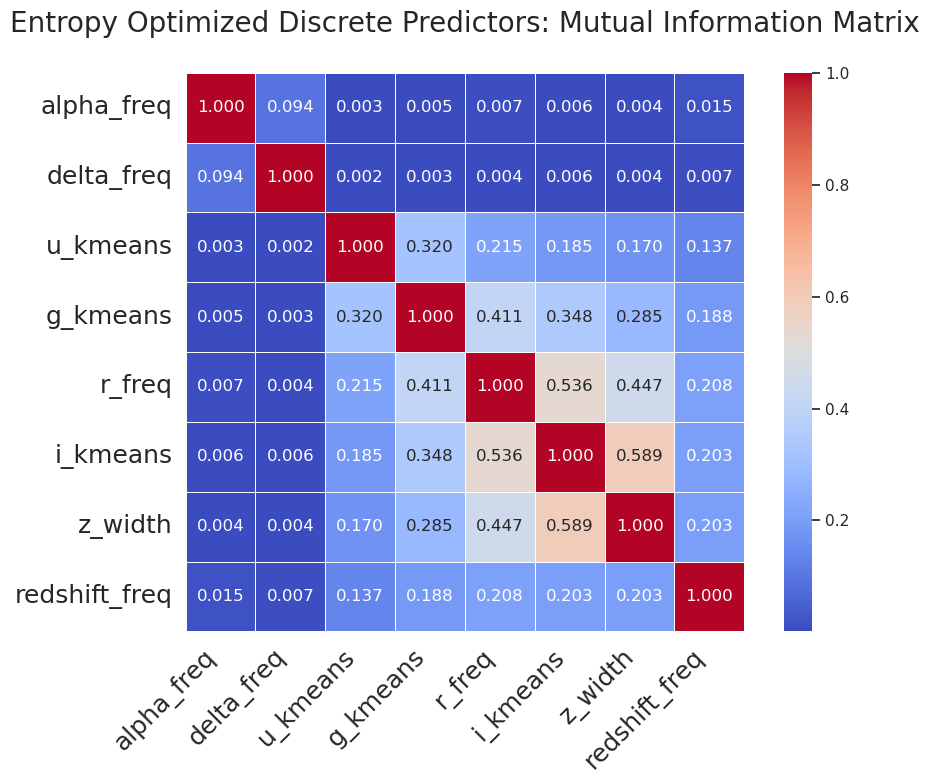

In [59]:
miChange_best_df = pd.read_csv("../Dataset/TestGroup_2b.csv")

cols = miChange_best_df.columns

# because numpy matrix, adds var names back in
best_df_mi_matrix = pd.DataFrame(discrete_mi(miChange_best_df), index= cols, columns=cols)
best_df_mi_matrix

best_df_mi_matrix.style\
    .format(precision = 3)\
    .format_index(str.upper, axis = 0)\
    .format_index(str.upper, axis = 1)\
    .background_gradient(cmap='coolwarm')

plt.figure(figsize=(10, 8))

sns.heatmap(best_df_mi_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Entropy Optimized Discrete Predictors: Mutual Information Matrix\n", 
          fontsize = 20
          )
plt.xticks(rotation=45, ha='right',
           fontsize = 18
           )
plt.yticks(rotation=0, 
           fontsize = 18
           )
plt.tight_layout()

# To save the plot
plt.savefig("../IMGs/EntDiscrete_Predictors_miheatmap.png", dpi=300)
plt.show()


### Test Group 2_c: intentionally the same as 1_c

In [184]:
randomPredict_df.to_csv("../Dataset/TestGroup_2c.csv",index = False)